In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from scipy.interpolate import interp2d
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from labellines import labelLine
from PIL import Image
import geopandas as gpd

In [2]:
cities_populations = pd.DataFrame(columns=['city', 'population'])
for name in ['miami', 'ma', 'bogota']:
    pop = pd.read_csv(f'confinement/cities3/{name}/Poparea.txt', sep=' ', header=None)[1].sum()
    cities_populations = pd.concat([cities_populations, pd.DataFrame([[name, pop]], columns=['city', 'population'])])
cities_populations = cities_populations.set_index('city')['population']
cities_populations

city
miami     5590269
ma        4146213
bogota    7129506
Name: population, dtype: object

# Fig 3

In [3]:
EPSG = 'EPSG:21897'
impact_path = "figures/impact_map"
links_path = "figures/links_map"

impact_Norm = Normalize()

try:
    zcta
except NameError:
    ZAT_index = pd.read_csv(f"{impact_path}/bogota/zat_index.txt", sep=" ", header=None, names=["ZAT", "index"])
    ZAT = gpd.read_file(f"{impact_path}/bogota/ZAT/ZAT.shp")[['ZAT', 'geometry']].to_crs(EPSG)
    ZAT = ZAT.merge(ZAT_index, on="ZAT")
    
    zcta = gpd.read_parquet('zcta.parquet')

    # zcta = gpd.read_file(f'{impact_path}/geo/zcta510/tl_2020_us_zcta510.shp')
    # zcta = zcta.astype({'ZCTA5CE10': 'int64'})

statename = 'fl'
city = 'miami'

states_fips = pd.read_csv(f'{impact_path}/geo/states_fips.txt',sep=',', index_col=0)
statefip = states_fips.loc[statename,'FIPS']


zcta_index = pd.read_csv(f'{impact_path}/cities3/'+city+'/zcta_index.csv', sep=' ')#.reset_index()
zcta_index = zcta.merge(zcta_index, left_on='ZCTA5CE10', right_on='zcta')
zcta_index = zcta_index.sort_values('zcta_index')[['zcta', 'zcta_index', 'geometry']].rename(columns={'zcta_index':'index'})

def plot_impact_map_miami(links, ax):
    city = 'miami'
    attackRate=pd.read_csv(
        f'map_impact_confinement/out/map_impact_confinement/{city}_beta_4,0_200k_links_{links}.txt', sep='\t')
    attackRate = pd.merge(zcta_index, attackRate, left_on='index', right_on='index')

    attackRate.plot('origin_mean', ax=ax, cmap = mpl.colormaps.get_cmap('viridis'), linewidth=0, alpha=1, norm=Normalize())#, norm=Normalize(vmin=0, vmax=1))

    # ax.set_xlim(-71.2, -71.0)
    # ax.set_ylim(42.25, 42.45)

    #remove axis
    ax.set_axis_off()


def plot_impact_map_bogota(links,ax):
    attackRate=pd.read_csv(
        f'map_impact_confinement/out/map_impact_confinement/bogota_beta_4,0_200k_links_{links}.txt', sep='\t')
    attackRate = pd.merge(ZAT, attackRate, left_on='index', right_on='index')
    attackRate.plot('origin_mean', ax=ax, cmap = mpl.colormaps.get_cmap('viridis'), norm=Normalize())

    #remove axis
    ax.set_axis_off()



In [4]:
def scaleMap(ax, scale):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    scale = 0.8
    x0,x1 = (x1 + x0) / 2 - (x1 - x0)/2 * scale, (x1 + x0) / 2 + (x1 - x0)/2 * scale
    y0,y1 = (y1 + y0) / 2 - (y1 - y0)/2 * scale, (y1 + y0) / 2 + (y1 - y0)/2 * scale
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)

def translateMap(ax, x, y):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    x0,x1 = x0 + x*(x1-x0), x1 + x*(x1-x0)
    y0,y1 = y0 + y*(y1-y0), y1 + y*(y1-y0)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)

links_Norm = Normalize()

def plot_links_bogota(Nlc, ax):
    chosenLinks = pd.read_csv(f"{links_path}/chosen_links/{Nlc}_bogota.txt", sep = "\t", header = None, names = ['i_index', 'j_index', 'population'])
    # Get the ZAT of each link
    chosenLinksZAT = pd.merge(
        chosenLinks, ZAT_index, left_on = 'i_index', right_on = 'index', how = 'left').merge(
        ZAT_index, left_on = 'j_index', right_on = 'index', how = 'left')[['ZAT_x', 'ZAT_y', 'population']].rename(columns={'ZAT_x': 'i_ZAT', 'ZAT_y': 'j_ZAT'})


    mobnetwork = pd.read_csv(f'{links_path}/chosen_links/ALL_bogota.txt', sep = "\t", header = None, names = ['i_index', 'j_index', 'population'])
    # Get the ZAT of each link
    mobnetworkZAT = pd.merge(
        mobnetwork, ZAT_index, left_on = 'i_index', right_on = 'index', how = 'left').merge(
        ZAT_index, left_on = 'j_index', right_on = 'index', how = 'left')[['ZAT_x', 'ZAT_y', 'population']].rename(columns={'ZAT_x': 'i_ZAT', 'ZAT_y': 'j_ZAT'})

    chosen_dest = chosenLinksZAT.groupby('j_ZAT')['population'].sum().reset_index().rename(columns={'population': 'chosen_dest', 'j_ZAT': 'ZAT'})
    total_dest = mobnetworkZAT.groupby('j_ZAT')['population'].sum().reset_index().rename(columns={'population': 'total_dest', 'j_ZAT': 'ZAT'})

    ZAT_destinations = pd.merge(ZAT, chosen_dest, on = 'ZAT', how = 'left').merge(total_dest, on = 'ZAT', how = 'left').fillna(0)

    ZAT_destinations['ratio'] = ZAT_destinations['chosen_dest'] / ZAT_destinations['total_dest']

    ZAT_destinations['total_tests_dest'] = (ZAT_destinations['chosen_dest'] / (ZAT_destinations.sum()['chosen_dest']))# / ZAT_destinations['total_dest']

    ZAT_destinations.plot('total_tests_dest', ax=ax, cmap = mpl.colormaps.get_cmap('viridis'), linewidth=0, alpha=1, norm=Normalize())
    # ZAT.boundary.plot(ax=ax, color='black', linewidth=0.3, alpha=1)

    ax.axis('off')


def plot_links_miami(Nlc, ax):

    chosenLinks = pd.read_csv(f"{links_path}/chosen_links/{Nlc}_{city}.txt", sep = "\t", header = None, names = ['i_index', 'j_index', 'population'])
    # Get the ZAT of each link
    chosenLinks_zcta = pd.merge(
        chosenLinks, zcta_index, left_on = 'i_index', right_on = 'index', how = 'left').merge(
        zcta_index, left_on = 'j_index', right_on = 'index', how = 'left')[['zcta_x', 'zcta_y', 'population']].rename(columns={'zcta_x': 'i_zcta', 'zcta_y': 'j_zcta'})


    mobnetwork = pd.read_csv(f'{links_path}/chosen_links/ALL_{city}.txt', sep = "\t", header = None, names = ['i_index', 'j_index', 'population'])
    # Get the ZAT of each link
    mobnetwork_zcta = pd.merge(
        mobnetwork, zcta_index, left_on = 'i_index', right_on = 'index', how = 'left').merge(
        zcta_index, left_on = 'j_index', right_on = 'index', how = 'left')[['zcta_x', 'zcta_y', 'population']].rename(columns={'zcta_x': 'i_zcta', 'zcta_y': 'j_zcta'})

    chosen_dest = chosenLinks_zcta.groupby('j_zcta')['population'].sum().reset_index().rename(columns={'population': 'chosen_dest', 'j_zcta': 'zcta'})
    total_dest = mobnetwork_zcta.groupby('j_zcta')['population'].sum().reset_index().rename(columns={'population': 'total_dest', 'j_zcta': 'zcta'})

    zcta_destinations = pd.merge(zcta_index, chosen_dest, on = 'zcta', how = 'left').merge(total_dest, on = 'zcta', how = 'left').fillna(0)

    zcta_destinations['ratio'] = (zcta_destinations['chosen_dest'] / zcta_destinations['total_dest']).fillna(0)

    zcta_destinations['total_tests_dest'] = (zcta_destinations['chosen_dest'] / (zcta_destinations.sum()['chosen_dest']))# / ZAT_destinations['total_dest']

    zcta_destinations.plot('total_tests_dest', ax=ax, cmap = mpl.colormaps.get_cmap('viridis'), linewidth=0, alpha=1, norm=Normalize())
    # ZAT.boundary.plot(ax=ax, color='black', linewidth=0.3, alpha=1)

    ax.axis('off')
    

In [5]:


def plot_attackRate_bogota(ax):

    name = 'bogota'
    beta_max,beta_min = 4, 1

    heatmap = pd.read_csv(f'confinement/out/attackRateMap/{name}.txt', sep='\t', names=['beta','links', 'attackRate', 'error'])
    heatmap = heatmap[heatmap['beta'] <= beta_max]
    heatmap['attackRate'] = heatmap['attackRate'] / cities_populations.loc[name]
    # heatmap = heatmap[heatmap['beta'].isin(heatmap['beta'].drop_duplicates()[::2]) & ((heatmap['beta'] > 1.7) | (heatmap['beta']==1.5))]
    # heatmap = heatmap.drop(heatmap[heatmap['beta'].isin([1])].index, axis=0)
    pivotTable = pd.pivot_table(data = heatmap, index = 'beta', columns = 'links', values='attackRate')

    linearColor = mpl.colormaps['inferno_r']
    for i,val in enumerate(heatmap['beta'].drop_duplicates()):
        links_text = 45203
        color=linearColor((val-beta_min)/(beta_max-beta_min))
        ax.plot('links', 'attackRate', data=heatmap[heatmap['beta']==val], color=color, label=f'{val:.2f}')
        # ax.text(links_text, heatmap[(heatmap['beta']==val) & (heatmap['links']==links_text)]['attackRate'].max(),
        #         r'$R_0$ = ' + f'{val:.2f}', color=color, fontsize=8, bbox=dict(facecolor='white', alpha=1, pad=-1), ha='center', va='center')

    labelLines(ax.get_lines(), zorder=2.5, xvals=(35000, 48000), outline_width=5, fontsize=10)

    # COLORBAR
    sm = plt.cm.ScalarMappable(cmap=linearColor, norm=Normalize(vmin=beta_min, vmax=beta_max))
    #sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)

    ax.set_xlabel('Links', size=20)
    ax.set_ylabel('Attack Rate', size=20)
    ax.tick_params(labelsize=16)

    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)

    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel(r'$R_0$', size=20)

    ax.grid('True')

    ax.set_ylim(0,)

def plot_attackRate_miami(ax1):

    label_size = 16
    abc_size = 16*1.6

    beta_max,beta_min = 4, 1.5
    name = 'miami'

    heatmap = pd.read_csv(f'confinement/out/attackRateMap/{name}.txt', sep='\t')
    heatmap = heatmap[(heatmap['beta'] <= beta_max) & (heatmap['beta'] > beta_min)]
    heatmap['attackRate'] = heatmap['attackRate'] / cities_populations.loc[name]


    pivotTable = pd.pivot_table(data = heatmap, index = 'beta', columns = 'links', values='attackRate')

    linearColor = mpl.colormaps['inferno_r']
    for i,val in enumerate(heatmap['beta'].drop_duplicates()):
        links_text = 11472
        color=linearColor((val-beta_min)/(beta_max-beta_min))
        ax1.plot('links', 'attackRate', data=heatmap[heatmap['beta']==val], color=color, label=f'{val:.1f}')
        # ax1.text(links_text, heatmap[(heatmap['beta']==val) & (heatmap['links']==links_text)]['attackRate'].max(),
        #         r'$R_0$ = ' + f'{val:.2f}', color=color, fontsize=8, bbox=dict(facecolor='white', alpha=1, pad=-1), ha='center', va='center')

    labelLines(plt.gca().get_lines(), zorder=2.5, xvals=(8000, 12000), outline_width=5, fontsize=10)

    # COLORBAR
    sm = plt.cm.ScalarMappable(cmap=linearColor, norm=Normalize(vmin=beta_min, vmax=beta_max))
    #sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax1)

    ax1.set_xlabel('Links', size=label_size)
    ax1.set_ylabel('Attack Rate', size=label_size)
    ax1.tick_params(labelsize=label_size)
    ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
    # ax1.xaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')
    # ax1.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')
    ax1.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)
    ax1.xaxis.offsetText.set_fontsize(label_size*0.8)
    ax1.yaxis.offsetText.set_fontsize(label_size*0.8)

    cbar.ax.tick_params(labelsize=label_size)
    cbar.ax.set_ylabel(r'$R_0$', size=label_size)

    ax1.grid('True')
    ax1.set_ylim(0,)
    ax1.set_xlim(0,)



/tmp/ipykernel_9844/296282416.py:41: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ZAT_destinations['total_tests_dest'] = (ZAT_destinations['chosen_dest'] / (ZAT_destinations.sum()['chosen_dest']))# / ZAT_destinations['total_dest']
/tmp/ipykernel_9844/296282416.py:71: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  zcta_destinations['total_tests_dest'] = (zcta_destinations['chosen_dest'] / (zcta_destinations.sum()['chosen_dest']))# / ZAT_destinations['total_dest']


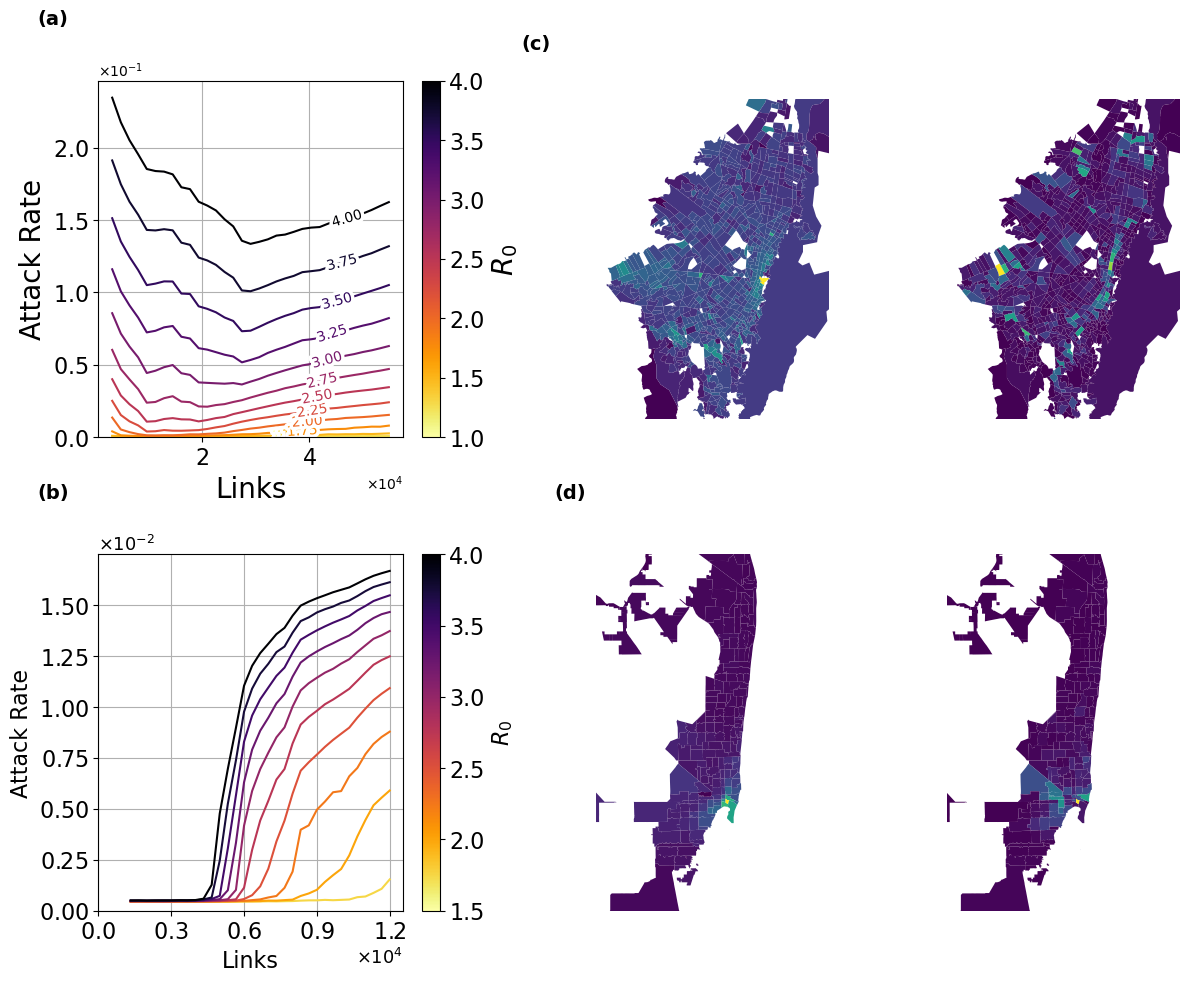

In [6]:
fig,axes = plt.subplot_mosaic('acx;bdy', figsize=(12, 10), width_ratios=[0.40, 0.27, 0.27], height_ratios=[1,1], layout="tight")
plot_attackRate_bogota(axes['a'])
plot_attackRate_miami(axes['b'])
plot_impact_map_bogota('28k', axes['c'])
plot_links_bogota('28000', axes['x'])
plot_impact_map_miami('6k', axes['d'])
plot_links_miami('6000', axes['y'])

scaleMap(axes['c'], 0.6)
translateMap(axes['c'], -0.2,0)
scaleMap(axes['x'], 0.8)
translateMap(axes['x'], -0.2,0)

scaleMap(axes['d'], 0.6)
translateMap(axes['d'], 0.3,0)
scaleMap(axes['y'], 0.6)
translateMap(axes['y'], 0.3,0)


for ax in axes.values():
    if ax.get_label() not in ['x', 'y']:
        ax.text(-0.2, 1.2, '('+ax.get_label()+')', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')


fig.tight_layout(h_pad=-2.0, w_pad=0)

In [9]:
fig.savefig('figures/Fig3.pdf', dpi=300, bbox_inches='tight')

/tmp/ipykernel_11558/296282416.py:41: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ZAT_destinations['total_tests_dest'] = (ZAT_destinations['chosen_dest'] / (ZAT_destinations.sum()['chosen_dest']))# / ZAT_destinations['total_dest']
/tmp/ipykernel_11558/296282416.py:71: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  zcta_destinations['total_tests_dest'] = (zcta_destinations['chosen_dest'] / (zcta_destinations.sum()['chosen_dest']))# / ZAT_destinations['total_dest']


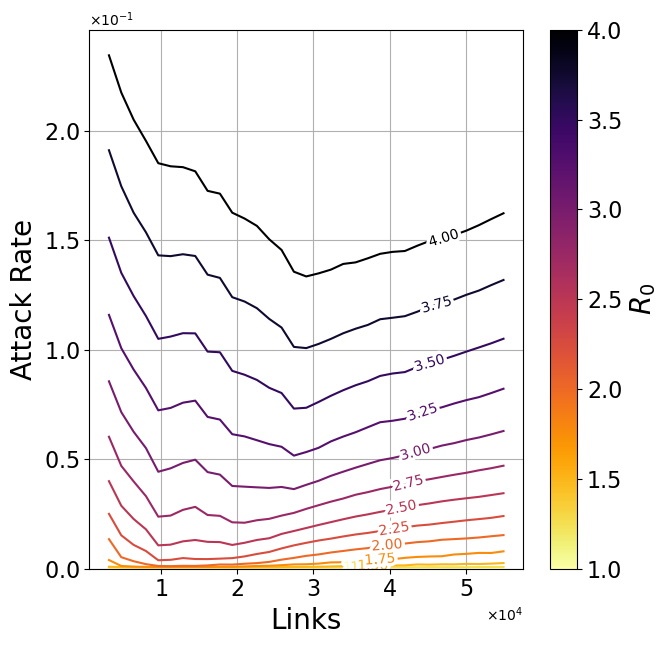

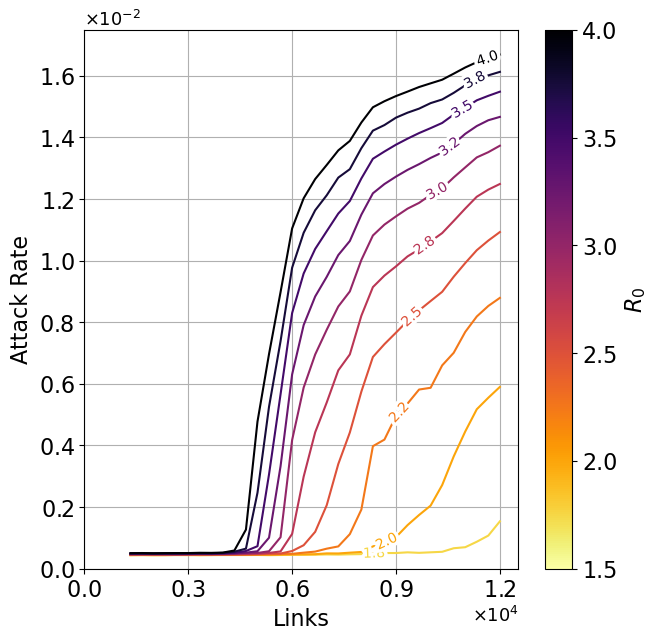

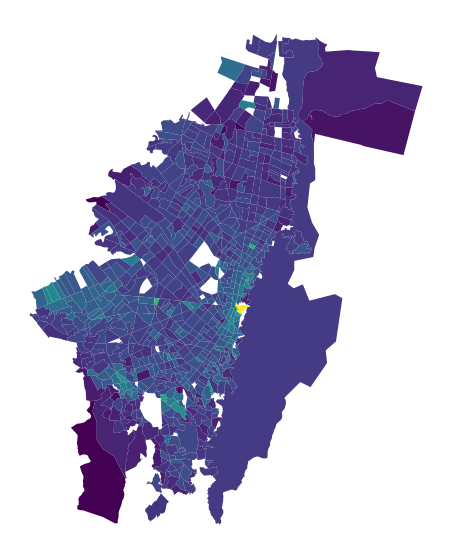

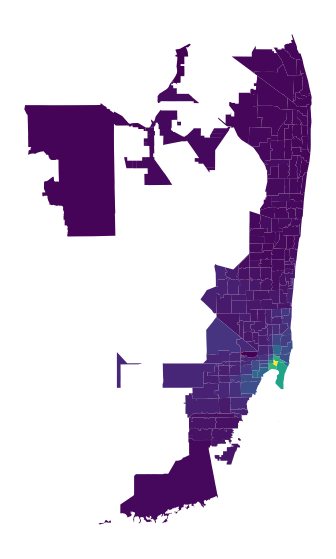

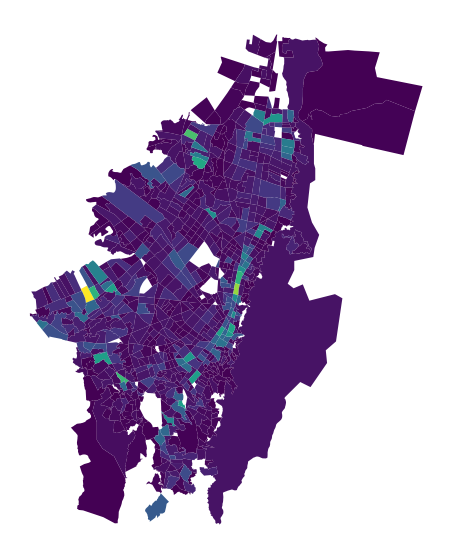

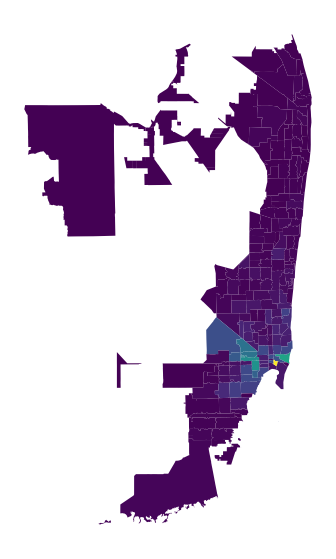

In [6]:
#plot the same figures as below but separately in different figures
fig,ax=plt.subplots(figsize=(7,7))
plot_attackRate_bogota(ax)
fig.savefig('figures/figs_feb24/individuales/Fig3a.pdf', bbox_inches='tight')

fig,ax=plt.subplots(figsize=(7,7))
plot_attackRate_miami(ax)
fig.savefig('figures/figs_feb24/individuales/Fig3b.pdf', bbox_inches='tight')

fig,ax=plt.subplots(figsize=(7,7))
plot_impact_map_bogota('28k',ax)
fig.savefig('figures/figs_feb24/individuales/Fig3c.pdf', bbox_inches='tight')

fig,ax=plt.subplots(figsize=(7,7))
plot_impact_map_miami('6k',ax)
fig.savefig('figures/figs_feb24/individuales/Fig3d.pdf', bbox_inches='tight')

fig,ax=plt.subplots(figsize=(7,7))
plot_links_bogota('28000',ax)
fig.savefig('figures/figs_feb24/individuales/Fig3e.pdf', bbox_inches='tight')

fig,ax=plt.subplots(figsize=(7,7))
plot_links_miami('6000',ax)
fig.savefig('figures/figs_feb24/individuales/Fig3f.pdf', bbox_inches='tight')


/tmp/ipykernel_18694/2806365539.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('inferno_r')


(0.0, 300.0)

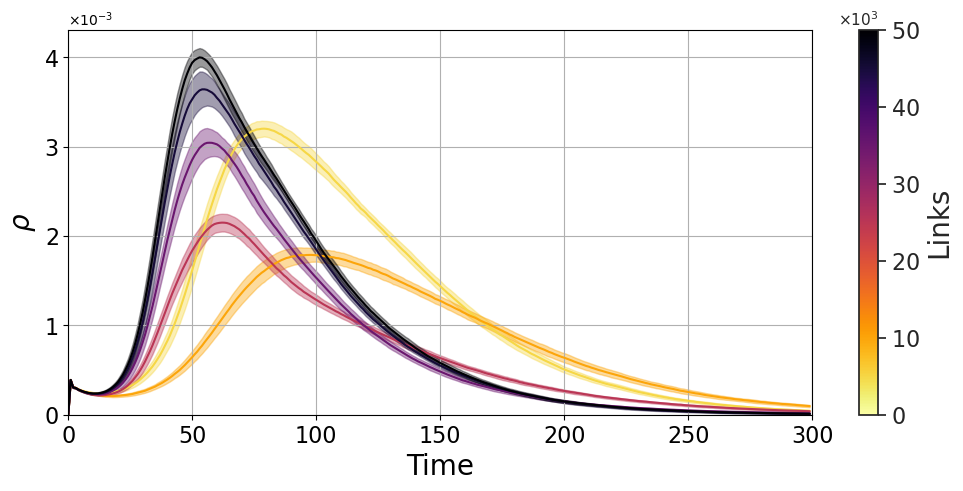

In [6]:
fig,ax = plt.subplots(figsize=(12,5))
label_size = 16
abc_size = 16*1.6

# data = pd.read_csv('curves_confinement/out/trajectories/ma_beta_4,0_80k.txt', sep='\t') //OLD ONE
name = 'bogota'
data = pd.read_csv(f'curves_confinement/out/trajectories/{name}_beta_3,0_150k.txt', sep='\t')
data['error'] = data['error'] * np.sqrt(1)
data['infected'] = data['infected'] / cities_populations.loc['bogota']
data['error'] = data['error'] / cities_populations.loc['bogota']

links = data['links'].drop_duplicates()
# links = links[links.isin([1237, 2474, 3711, 6185, 12371, 22269, 40826])]

colors = cm.get_cmap('inferno_r')

sns.set_theme(style="ticks")

for l in links:
    ax.plot('time', 'infected', color = colors((l)/(links.max())), data=data[data['links'] == l],
        label=l)
    ax.fill_between(x=data[data['links'] == l]['time'], y1=data[data['links'] == l]['infected']+ 2*data[data['links'] == l]['error'],
        y2=data[data['links'] == l]['infected']-2*data[data['links'] == l]['error'], color=colors((l)/(links.max())), alpha=0.4) 
sm = plt.cm.ScalarMappable(cmap=colors, norm=Normalize(0, links.max()))
cbar=fig.colorbar(sm, ax=ax)


ax.set_xlabel('Time', size=20)
ax.set_ylabel(r'$\rho$', size=20)
ax.tick_params(labelsize=16)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('Links', size=20)
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3), useMathText=True)

ax.grid('True')
ax.set_ylim(0,)
ax.set_xlim(0, 300)


In [9]:
fig.savefig(f'figures/figs_feb24/individuales/Fig2c.pdf', bbox_inches='tight', dpi=300)

In [7]:
label_size = 16
abc_size = 16*1.6

colormap = mpl.colormaps['inferno_r']

name = 'bogota'
betastr = '4,0'

def plot_infected_time_bogota(ax):
    curves = pd.read_csv('curves_times/out/bogota_20k_180d_beta_4,0.txt', sep='\t')
    total_infected = curves[curves['links']==0]
    curves = curves.drop(curves[curves['links']==0].index)
    curves['cumulative_infected'] = curves.groupby('links')['infected'].cumsum(axis=0)

    ax.plot('time', 'infected', data=total_infected, label='', color = mpl.colormaps['inferno_r'](0.9), lw=2)
    ax.set_xlim(0,)
    ax.set_ylim(0,)

    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)


    ax.set_xlabel('Time', size=label_size)
    ax.set_ylabel(r'$\rho$', size=label_size)
    ax.tick_params(labelsize=label_size)

def plot_detected_time_bogota(ax1):
    curves = pd.read_csv('curves_times/out/bogota_20k_180d_beta_4,0.txt', sep='\t')
    curves = curves.drop(curves[curves['links']==0].index)
    curves['cumulative_infected'] = curves.groupby('links')['infected'].cumsum(axis=0)
    links_list = curves['links'].unique()
    ax1.axhline(y=1000, color='grey', linestyle='--')
    for i,links in enumerate(links_list):
        ax1.plot('time', 'cumulative_infected', data = curves[curves['links']==links], lw=2, 
                color = colormap(i/(len(links_list)-1)), label = '{:.0f}'.format(links/1000) +r'$\times 10^3$ links')
    ax1.set_xlim(0,50)
    ax1.set_ylim(0,2000)
    ax1.legend()

    # only one digit per tick on the y axis

    ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

    ax1.set_xlabel('Time', size=label_size)
    ax1.set_ylabel('Detected', size=label_size)
    ax1.tick_params(labelsize=label_size)

In [8]:
label_size = 16
abc_size = 16*1.6


def plot_EWT_betas(ax):
    name = 'bogota'
    betastr = '4,0'
    colormap = mpl.colormaps['viridis']

    for i,betastr in enumerate(['2,0', '3,0', '4,0']):
        heatmap = pd.read_csv('times/out/' + name + f'_{20}k_120d_beta_' + betastr +
                                '.txt', sep='\t')
        heatmap['time'] = heatmap['time'].rolling(window=4).mean()
        heatmap['time_error'] = heatmap['time_error'].rolling(window=4).mean()
        heatmap['time_error'] = heatmap['time_error']/np.sqrt(23) * 1.96
    

        #rolling average of data
        color = colormap(i/3)
        ax.plot('population', 'time', data=heatmap, color=color, lw=2, label = r'$R_0 = $' + str(betastr))
        ax.fill_between(x=heatmap['population'], y1=heatmap['time']+ 1*heatmap['time_error'], y2=heatmap['time']-1*heatmap['time_error'], color=color, alpha=0.2)

    ax.legend(fontsize=label_size*0.8)
    ax.set_xlabel('Population', size=label_size)
    ax.set_ylabel('EWT (days)', size=label_size)
    ax.tick_params(labelsize=label_size)
    ax.set_xlim(0,6000000)
    ax.set_ylim(0,)
    ax.grid('True')
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)

def plot_EWT_tests(ax):
    name = 'bogota'
    colormap = mpl.colormaps['viridis']
    betastr = '4,0'
    for i,testsstr in enumerate(['10k', '20k', '30k']):
        heatmap = pd.read_csv(f'times/out/{name}_{testsstr}_60d_beta_{betastr}.txt', sep='\t')

        tests_labels = [r'$1 \times 10^4$', r'$2 \times 10^4$', r'$3 \times 10^4$']

        total_tests_done = heatmap['tests'].iloc[0]
        color = colormap(i/3)
        ax.plot(heatmap['population'], heatmap['time'], color=color, lw=2, label = r'$Tests = $' + tests_labels[i])
        ax.fill_between(x=heatmap['population'], y1=heatmap['time'] + 1*heatmap['time_error'], y2=heatmap['time'] - 1*heatmap['time_error'], color=color, alpha=0.2)

    ax.legend(fontsize=label_size*0.8)

    ax.set_xlabel('Population', size=label_size)
    ax.set_ylabel('EWT (days)', size=label_size)
    ax.tick_params(labelsize=label_size)
    ax.set_xlim(0,3000000)
    ax.set_ylim()
    ax.grid('True')
    
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)

In [9]:
sns.set_theme(style="ticks")


label_size = 16
abc_size = 16*1.6

def plot_detected_betas(ax):
    name = 'bogota'
    colormap = mpl.colormaps['viridis']
    for i,betastr in enumerate(['2,0', '3,0', '4,0']):
        heatmap = pd.read_csv('times/out/' + name + '_20k_30d_beta_' + betastr + '.txt', sep='\t')

        total_tests_done = heatmap['tests'].iloc[0]
        color = colormap(i/3)
        ax.plot(heatmap['population'], heatmap['detected']/total_tests_done, color=color, lw=2, label = r'$R_0 = $' + betastr)
        ax.fill_between(x=heatmap['population'], y1=heatmap['detected']/total_tests_done+ 1*heatmap['error']/total_tests_done, y2=heatmap['detected']/total_tests_done-1*heatmap['error']/total_tests_done, color='gray', alpha=0.4)

    ax.legend(fontsize=label_size*0.9)

    ax.set_xlabel('Population', size=label_size)
    ax.set_ylabel('Detected', size=label_size)
    ax.tick_params(labelsize=label_size)
    ax.set_xlim(0,6000000)
    ax.set_ylim(0,0.03)
    ax.grid('True')
    
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)

def plot_detected_tests(ax):
    name = 'bogota'
    colormap = mpl.colormaps['viridis']
    betastr = '4,0'
    for i,testsstr in enumerate(['10k', '20k']):
        heatmap = pd.read_csv(f'times/out/{name}_{testsstr}_60d_beta_{betastr}.txt', sep='\t')

        total_tests_done = heatmap['tests'].iloc[0]
        color = colormap(i/3)
        ax.plot(heatmap['population'], heatmap['detected']/total_tests_done, color=color, lw=2, label = r'$Tests = $' + testsstr)
        ax.fill_between(x=heatmap['population'], y1=heatmap['detected']/total_tests_done+ 1*heatmap['error']/total_tests_done, y2=heatmap['detected']/total_tests_done-1*heatmap['error']/total_tests_done, color='gray', alpha=0.4)

    ax.legend(fontsize=label_size*0.9)

    ax.set_xlabel('Population', size=label_size)
    ax.set_ylabel('Detected', size=label_size)
    ax.tick_params(labelsize=label_size)
    ax.set_xlim(0,3000000)
    ax.set_ylim(0,0.06)
    ax.grid('True')
    
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)

Text(0.51, 0.32, '(e)')

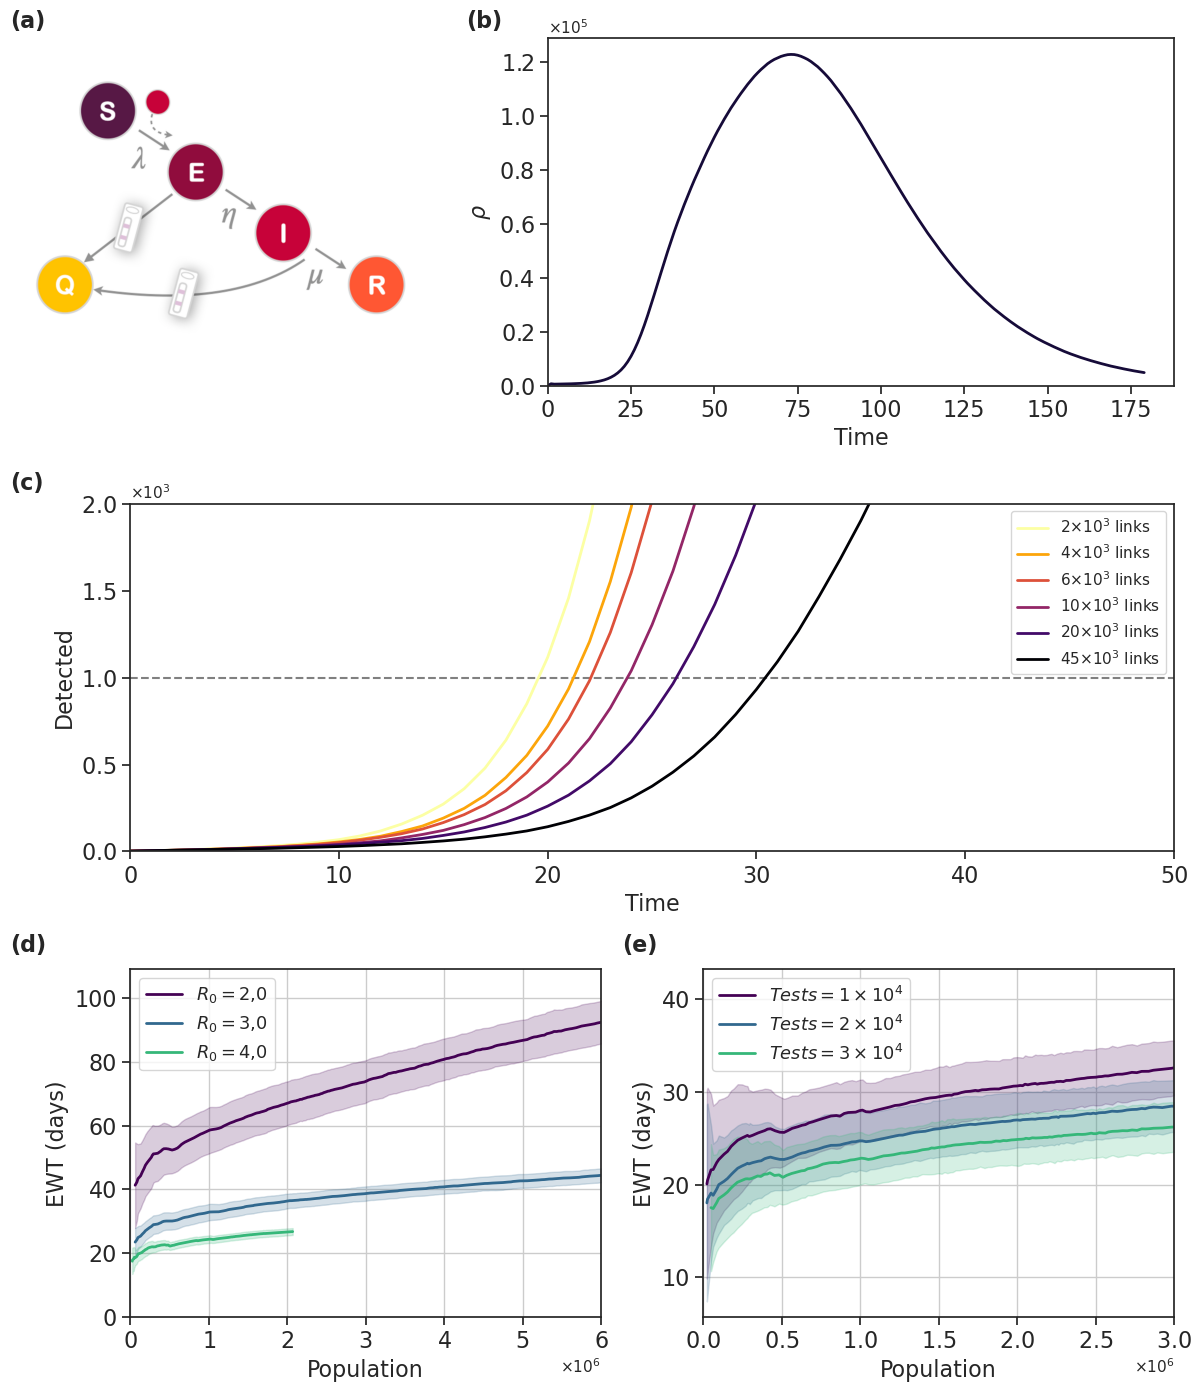

In [10]:
fig,axes = plt.subplot_mosaic('aaabbbb;.cccccc;.dddeee', figsize=(12, 14), height_ratios=[1,1,1], width_ratios=[0,1,1,0.5,0.5,1,1])

img = Image.open('figures/SEIR.png')
#img = Image.open(BytesIO())
axes['a'].axis('off')
#plot the image bigger
axes['a'].imshow(img)

plot_infected_time_bogota(axes['b'])
plot_detected_time_bogota(axes['c'])
plot_EWT_betas(axes['d'])
# plot_detected_betas(axes['e'])
# plot_detected_tests(axes['e'])
plot_EWT_tests(axes['e'])

fig.tight_layout(h_pad=2)


axes['a'].text(0    , 0.98, '(a)', transform=fig.transFigure, fontsize=16, fontweight='bold')
axes['b'].text(0.38 , 0.98, '(b)', transform=fig.transFigure, fontsize=16, fontweight='bold')
axes['c'].text(0    , 0.65, '(c)', transform=fig.transFigure, fontsize=16, fontweight='bold')
axes['d'].text(0    , 0.32, '(d)', transform=fig.transFigure, fontsize=16, fontweight='bold')
axes['e'].text(0.51  , 0.32, '(e)', transform=fig.transFigure, fontsize=16, fontweight='bold')



In [34]:
fig.savefig('figures/Fig4.pdf', bbox_inches='tight', dpi=300)

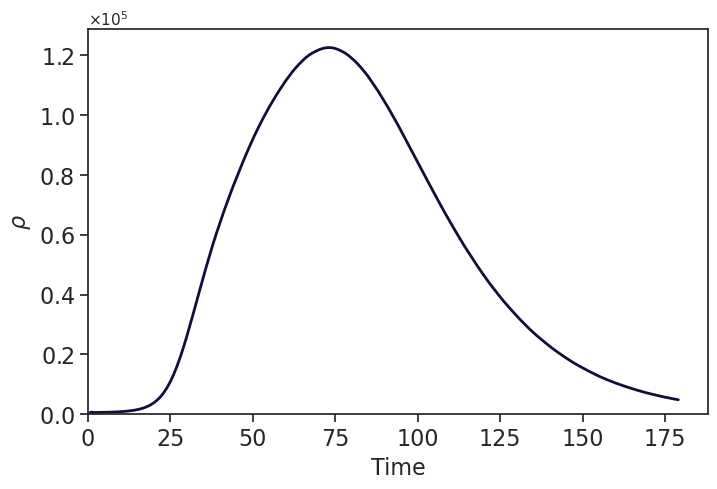

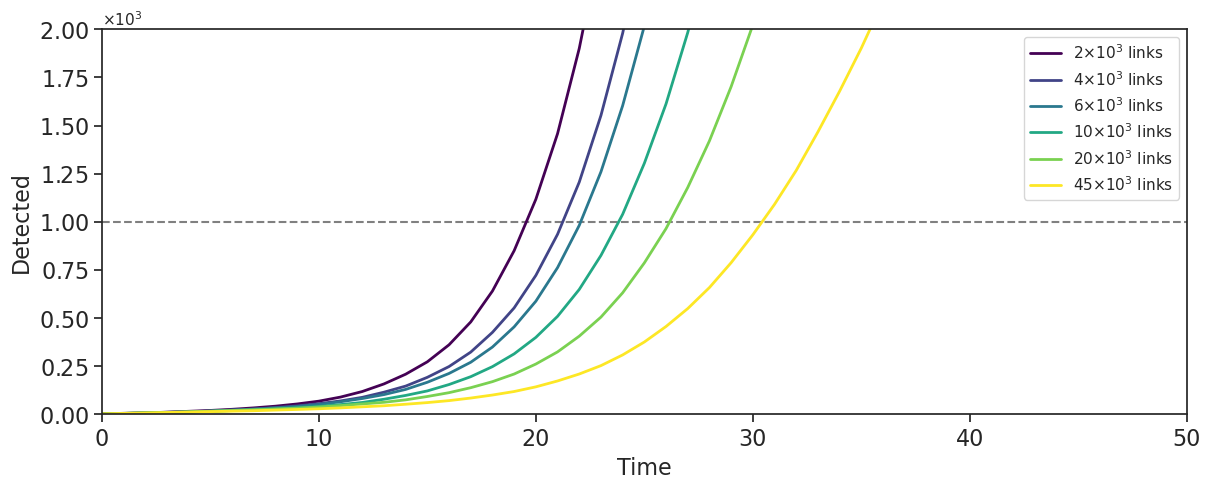

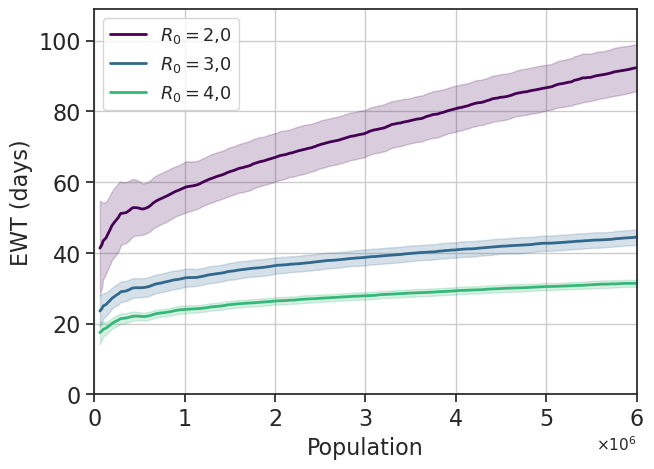

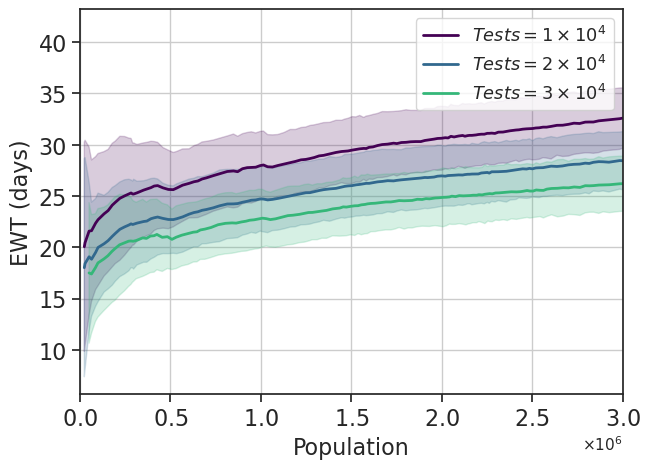

In [40]:
# plot the same figures as above but separately in different figures
fig,ax=plt.subplots(figsize=(8,5))
plot_infected_time_bogota(ax)
fig.savefig('figures/figs_feb24/individuales/Fig4b.pdf', bbox_inches='tight')

fig,ax=plt.subplots(figsize=(14,5))
plot_detected_time_bogota(ax)
fig.savefig('figures/figs_feb24/individuales/Fig4c.pdf', bbox_inches='tight')

fig,ax=plt.subplots(figsize=(7,5))
plot_EWT_betas(ax)
fig.savefig('figures/figs_feb24/individuales/Fig4d.pdf', bbox_inches='tight')

fig,ax=plt.subplots(figsize=(7,5))
plot_EWT_tests(ax)
fig.savefig('figures/figs_feb24/individuales/Fig4e.pdf', bbox_inches='tight')


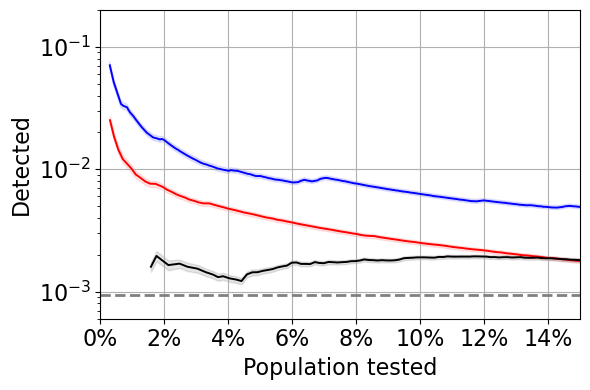

In [3]:
fig,ax = plt.subplots(figsize=(6,4))
label_size = 16
abc_size = 16*1.6

betastr = '4,0'
links = pd.read_csv('times/out/bogota_20k_30d_beta_' + betastr + '.txt', sep='\t')
transport = pd.read_csv('public_transport/times/out/bogota_transport_20k_30d_beta_' + betastr + '.txt', sep='\t')
transport_population = pd.read_csv('public_transport/times/out/population/bogota_transport_20k_30d_beta_' + betastr + '.txt', sep='\t')
lower = 566.25

colormap = mpl.colormaps['viridis_r']

max_days,min_days = 17,9

total_tests = 20000 * 30
errorNorm = 1/np.sqrt((24*8)-1) # number of simulations - 1 to go from std to error

ax.plot(links['population'], links['detected']/total_tests, label='Links', c = 'blue', lw=1.4)
ax.fill_between(x=links['population'], y1=(links['detected']+ errorNorm*links['error'])/total_tests, y2=(links['detected']-errorNorm*links['error'])/total_tests, color='blue', alpha=0.1)
ax.plot(transport['population'], transport['detected']/total_tests, label='Transport', c = 'red', lw=1.4)
ax.fill_between(x=transport['population'], y1=(transport['detected']+ errorNorm*transport['error'])/total_tests, y2=(transport['detected']-errorNorm*transport['error'])/total_tests, color='red', alpha=0.1)
ax.plot(transport_population['population'], transport_population['detected']/total_tests, label='Population', c = 'black', lw=1.4)

ax.fill_between(x=transport_population['population'], y1=(transport_population['detected']+ errorNorm*transport_population['error'])/total_tests, y2=(transport_population['detected']-errorNorm*transport_population['error'])/total_tests, color='black', alpha=0.1)


total_pop = cities_populations['bogota']

#Plot again the lines with alpha = 0 to set the legend
# ax.plot(links['population'], links['detected'], label='Links', alpha=0)
# ax.plot(transport['population'], transport['detected'], label='Transport', alpha=0)
ax.plot([0,7100000], [lower/total_tests, lower/total_tests], label='Random', c = 'grey', lw = 2, linestyle = 'dashed')

# labelLine(ax.get_lines()[-4], zorder=2.5, x=0.1*total_pop, outline_width=5, align=False, yoffset=0.001, color=colormap(0.8))
# labelLine(ax.get_lines()[-3], zorder=2.5, x=0.081*total_pop, outline_width=5, align=False, yoffset=0.0006, color='red')
# labelLine(ax.get_lines()[-2], zorder=2.5, x=0.04*total_pop, outline_width=5, align=False, yoffset=0.0005, color='black')
# labelLine(ax.get_lines()[-1], zorder=2.5, x=0.01*total_pop, outline_width=5, align=False, yoffset=0.00015, color='grey')

# ax.legend(fontsize=label_size)


ax.set_xlabel('Population tested', size=label_size)
ax.set_ylabel('Detected', size=label_size)
ax.tick_params(labelsize=label_size)
ax.set_xlim(0, 0.15*total_pop)
ax.set_ylim(0.0006,0.2)


ax.set_yscale('log')

# ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))

percentages = np.array([0,2,4,6,8,10,12,14]) * total_pop / 100
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(percentages))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/total_pop*100) + '%'))

ax.grid('True')

fig.tight_layout()
fig.show()
fig.savefig(f'figures/figs_feb24/individuales/Fig5c.pdf', bbox_inches='tight', dpi=300)

In [31]:
lower

26.7969

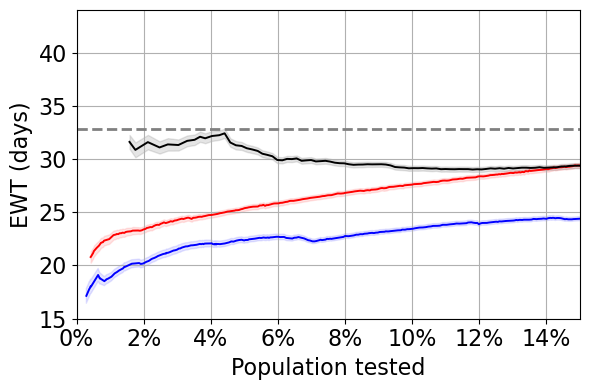

In [4]:
fig,ax = plt.subplots(figsize=(6,4))
label_size = 16
abc_size = 16*1.6

betastr = '4,0'
links = pd.read_csv('times/out/bogota_20k_120d_beta_' + betastr + '.txt', sep='\t')
transport = pd.read_csv('public_transport/times/out/bogota_transport_20k_120d_beta_' + betastr + '.txt', sep='\t')
transport_population = pd.read_csv('public_transport/times/out/population/bogota_transport_20k_120d_beta_' + betastr + '.txt', sep='\t')

lower = 32.8438 #days for links.iloc[-1], if links went to the last link (it cuts before)

colormap = mpl.colormaps['viridis_r']

total_tests = 20000 * 120

errorNorm = 1/np.sqrt((24*8)-1) # number of simulations - 1 to go from std to error

ax.plot(links['population'], links['time'], label='Links', c = 'blue', lw=1.4)
ax.fill_between(x=links['population'], y1=links['time']+ errorNorm*links['time_error'], y2=links['time']-errorNorm*links['time_error'], color='blue', alpha=0.1)

ax.plot(transport['population'], transport['time'], label='Transport', c = 'red', lw=1.4)
ax.fill_between(x=transport['population'], y1=transport['time']+ errorNorm*transport['time_error'], y2=transport['time']-errorNorm*transport['time_error'], color='red', alpha=0.1)

ax.plot(transport_population['population'], transport_population['time'], label='Population', c = 'black', lw=1.4)
ax.fill_between(x=transport_population['population'], y1=transport_population['time']+ errorNorm*transport_population['time_error'], y2=transport_population['time']-errorNorm*transport_population['time_error'], color='black', alpha=0.1)


total_pop = cities_populations['bogota']

#Plot again the lines with alpha = 0 to set the legend
# ax.plot(links['population'], links['detected'], label='Links', alpha=0)
# ax.plot(transport['population'], transport['detected'], label='Transport', alpha=0)
ax.plot([0,7100000], [lower, lower], label='Random', c = 'grey', lw = 2, linestyle = 'dashed')

# labelLine(ax.get_lines()[-4], zorder=2.5, x=0.1*total_pop, outline_width=2, align=False, yoffset=1, color=colormap(0.8))
# labelLine(ax.get_lines()[-3], zorder=2.5, x=0.081*total_pop, outline_width=2, align=False, yoffset=1, color='red')
# labelLine(ax.get_lines()[-2], zorder=2.5, x=0.04*total_pop, outline_width=2, align=False, yoffset=-2, color='black')
# labelLine(ax.get_lines()[-1], zorder=2.5, x=0.01*total_pop, outline_width=2, align=False, yoffset=1, color='grey')

# ax.legend(fontsize=label_size)


ax.set_xlabel('Population tested', size=label_size)
ax.set_ylabel('EWT (days)', size=label_size)
ax.tick_params(labelsize=label_size)
ax.set_xlim(0, 0.15*total_pop)
ax.set_ylim(15,44)


# ax.set_yscale('log')

# ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))

percentages = np.array([0,2,4,6,8,10,12,14]) * total_pop / 100
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(percentages))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/total_pop*100) + '%'))

ax.grid('True')

fig.tight_layout()
fig.show()
fig.savefig(f'figures/figs_feb24/individuales/Fig5d.pdf', bbox_inches='tight', dpi=300)

In [17]:
transport['population'].min()/cities_populations['bogota']

0.004213475660164954